In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import Model

# !! 注意 !! 訓練前需先執行過voc_annotation.py 檔 !!

### 參數設置

In [2]:
classes_path = 'model_data/cls_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
anchors_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
model_path      = 'model_data/yolo4_weight.h5'
train_annotation_path = 'Data/train/list/yolo_train.txt'
val_annotation_path = 'Data/train/list/yolo_val.txt'

class_names = ['ContainerNum']
num_classes = 1
input_shape = [416, 416]
Max_epoch = 10000
lr = 1e-3

In [3]:
def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path, encoding='utf-8') as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
    return anchors, len(anchors)

anchors, num_anchors = get_anchors(anchors_path)

In [4]:
Min_lr = lr * 0.01
Init_lr_fit = min(max(4 / 64 * lr, 3e-4), 1e-3)
Min_lr_fit = min(max(4 / 64 * Min_lr, 3e-4 * 1e-2), 1e-3 * 1e-2)
print('Init_lr_fit', Init_lr_fit)
print('Min_lr_fit', Min_lr_fit)

Init_lr_fit 0.0003
Min_lr_fit 2.9999999999999997e-06


## 載入資料

In [5]:
from utils.dataloader import YoloDatasets

with open(train_annotation_path, encoding='utf-8') as f:
    train_lines = f.readlines()
with open(val_annotation_path, encoding='utf-8') as f:
    val_lines   = f.readlines()

train_dataloader = YoloDatasets(train_lines, input_shape, anchors, batch_size=4, num_classes=1, anchors_mask=anchors_mask, epoch_now=0, epoch_length=Max_epoch, mosaic=True, train=True)
val_dataloader = YoloDatasets(val_lines, input_shape, anchors, batch_size=4, num_classes=1, anchors_mask=anchors_mask, epoch_now=0, epoch_length=Max_epoch, mosaic=False, train=False)

## 建立Yolo模型

In [6]:
from nets.yolo import yolo_body, get_train_model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

model_body  = yolo_body((416, 416, 3), anchors_mask, num_classes)
model_body.load_weights(model_path, by_name=True, skip_mismatch=True)

model_body.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
mish (Mish)                     (None, 416, 416, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## L2正則

In [7]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense
from tensorflow.keras.regularizers import l2

for layer in model_body.layers:
    if isinstance(layer, DepthwiseConv2D):
            layer.add_loss(lambda: l2(0)(layer.depthwise_kernel))
    elif isinstance(layer, Conv2D) or isinstance(layer, Dense):
            layer.add_loss(lambda: l2(0)(layer.kernel))

## 凍結權重

In [8]:
freeze_layers = 249

for i in range(freeze_layers):
    model_body.layers[i].trainable = False
    
print('Freeze the first {} layers of total {} layers.'.format(freeze_layers, len(model_body.layers)))

Freeze the first 249 layers of total 370 layers.


## 建立訓練模型

In [9]:
model = get_train_model(model_body, input_shape, num_classes, anchors, anchors_mask, label_smoothing=0.005, focal_loss=False, alpha=0.25, gamma=2)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
mish (Mish)                     (None, 416, 416, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr = lr, beta_1 = 0.937)

model.compile(optimizer = opt, loss={'yolo_loss': lambda y_true, y_pred: y_pred})

In [11]:
from  tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History, TensorBoard, LearningRateScheduler
from nets.yolo_training import get_lr_scheduler

checkpoint_callback = ModelCheckpoint('logs/best_epoch_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping  = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 120, verbose = 1)

lr_scheduler_func = get_lr_scheduler('cos', Init_lr_fit, Min_lr_fit, total_iters=Max_epoch)
lr_scheduler    = LearningRateScheduler(lr_scheduler_func, verbose = 1)

callbacks = [checkpoint_callback, lr_scheduler, early_stopping]

## 凍結訓練

In [12]:
history = model.fit(train_dataloader, epochs=Max_epoch, initial_epoch=0, validation_data=val_dataloader, callbacks=callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
Epoch 1/10000
3/3 [==============================] - ETA: 0s - loss: 18.8718
Epoch 00001: val_loss improved from inf to 18.75172, saving model to logs\best_epoch_weights.h5
3/3 [==============================] - 8s 3s/step - loss: 18.8718 - val_loss: 18.7517

Epoch 00002: LearningRateScheduler reducing learning rate to 5.9999999999999995e-05.
Epoch 2/10000
3/3 [==============================] - ETA: 0s - loss: 18.6345
Epoch 00002: val_loss improved from 18.75172 to 18.74543, saving model to logs\best_epoch_weights.h5
3/3 [==============================] - 6s 2s/step - loss: 18.6345 - val_loss: 18.7454

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00014999999999999996.
Epoch 3/10000
3/3 [==============================] - ETA: 0s - loss: 18.1275
Epoch 00003: val_loss improved from 18.74543 to 18.69491, saving model to logs\best_epoch_weights.h5
3/3 [==============================] - 5s

### 取得解凍時間點

In [13]:
stop_epoch = early_stopping.stopped_epoch + 1

## 解凍

In [14]:
for i in range(len(model_body.layers)): 
    model_body.layers[i].trainable = True

model.compile(optimizer = opt, loss={'yolo_loss': lambda y_true, y_pred: y_pred})

In [15]:
early_stopping  = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 350, verbose = 1)

callbacks = [checkpoint_callback, lr_scheduler, early_stopping]

## 微調訓練

In [16]:
history2 = model.fit(train_dataloader, epochs=Max_epoch, initial_epoch=stop_epoch, validation_data=val_dataloader, callbacks=callbacks)


Epoch 00669: LearningRateScheduler reducing learning rate to 0.0002967594517993756.
Epoch 669/10000
3/3 [==============================] - ETA: 0s - loss: 0.1344
Epoch 00669: val_loss did not improve from 0.07495
3/3 [==============================] - 3s 868ms/step - loss: 0.1344 - val_loss: 0.1139

Epoch 00670: LearningRateScheduler reducing learning rate to 0.0002967497341974705.
Epoch 670/10000
3/3 [==============================] - ETA: 0s - loss: 0.0920
Epoch 00670: val_loss did not improve from 0.07495
3/3 [==============================] - 1s 220ms/step - loss: 0.0920 - val_loss: 0.1102

Epoch 00671: LearningRateScheduler reducing learning rate to 0.0002967400022082437.
Epoch 671/10000
3/3 [==============================] - ETA: 0s - loss: 0.0993
Epoch 00671: val_loss did not improve from 0.07495
3/3 [==============================] - 1s 218ms/step - loss: 0.0993 - val_loss: 0.0844

Epoch 00672: LearningRateScheduler reducing learning rate to 0.0002967302558326591.
Epoch 672/10

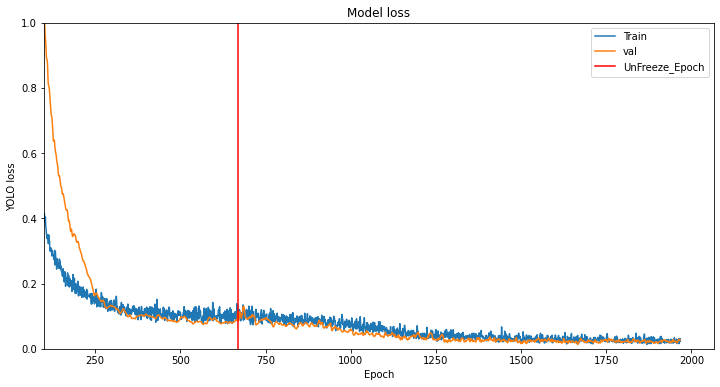

In [34]:
# Plotting the trajectory of loss function
plt.figure(figsize=(12,6))
plt.plot(history.history['loss']+history2.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss'])
plt.axvline(stop_epoch, color="red")
plt.title('Model loss')
plt.ylabel('YOLO loss')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(100)
plt.legend(['Train', 'val', 'UnFreeze_Epoch'], loc='upper right')
plt.show()

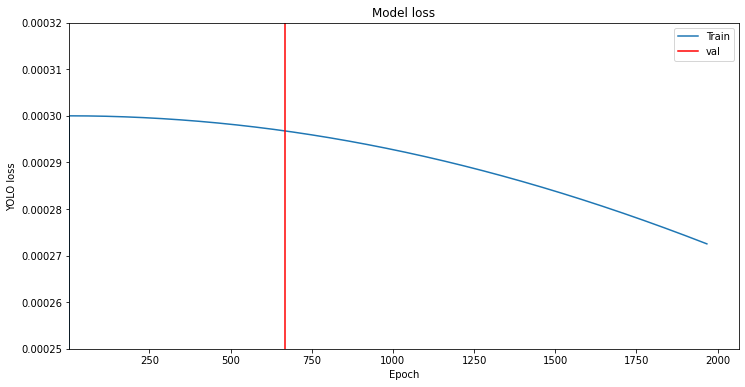

In [28]:
# Plotting the trajectory of loss function
plt.figure(figsize=(12,6))
plt.plot(history.history['lr']+history2.history['lr'])
plt.axvline(stop_epoch, color="red")
plt.title('Model loss')
plt.ylabel('YOLO loss')
plt.xlabel('Epoch')
plt.xlim(3)
plt.ylim(0.00025, 0.00032)
plt.legend(['Train', 'val', 'UnFreeze_Epoch'], loc='upper right')
plt.show()